<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-4/blob/main/AIML425_Assn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
! pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.2 MB/s eta 0:00:00


may need to retart kernel after install kaleido

In [ ]:
import numpy as np
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

import ot

import matplotlib.pyplot as plt
import plotly.express as px

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# 1. Generate 3D data

In [ ]:
def generate_points_on_cube_surface(n_points_per_face):
    """
    Generate points uniformly distributed over the surface of a cube.

    Parameters:
    - n_points_per_face: Number of points to generate on each face of the cube.

    Returns:
    - points: (3, 6*n_points_per_face) array of points on the cube surface.
    """
    faces = []
    for _ in range(6):
        face = np.random.rand(3, n_points_per_face)
        axis = _ // 2  # 0: x, 1: y, 2: z
        face[axis, :] = (_ % 2)  # 0 or 1, depending on the face
        faces.append(face)
    return np.hstack(faces)

n_points_per_face = 1000
points = generate_points_on_cube_surface(n_points_per_face)

fig = px.scatter_3d(x=points[0], y=points[1], z=points[2], opacity=0.5)
fig.show()


Create a dataset and dataloaders

In [ ]:
points = points.T

# 2. Create a dataset and dataloaders
dataset = TensorDataset(torch.tensor(points, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. Basic Autoencoder

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def plot_bottleneck_distribution(self, dataloader):
        all_outputs = []
        with torch.no_grad():
            for batch in dataloader:
                data = batch[0]
                encoded = self.encode(data).cpu().numpy()
                all_outputs.extend(encoded)

        all_outputs = np.array(all_outputs)

        # Number of dimensions in the bottleneck layer
        num_dims = all_outputs.shape[1]

        # Plot histograms for each dimension
        fig, axs = plt.subplots(1, num_dims, figsize=(4*num_dims, 5))

        for i in range(num_dims):
            axs[i].hist(all_outputs[:, i], bins=50, alpha=0.7)
            axs[i].set_title(f'Distribution of Dimension {i+1}')
            axs[i].set_xlabel(f'Value')
            axs[i].set_ylabel(f'Frequency')

        plt.tight_layout()
        plt.show()


# manual tuning the model, it gives best decoder output when bottleneck dim is 7.

In [ ]:
def train_autoencoder():
    bottleneck_dim = 7
    model = Autoencoder(bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        for data, in dataloader:
            outputs = model(data)
            loss = criterion(outputs, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    model.plot_bottleneck_distribution(dataloader)

## Train Auto encoder Round 1

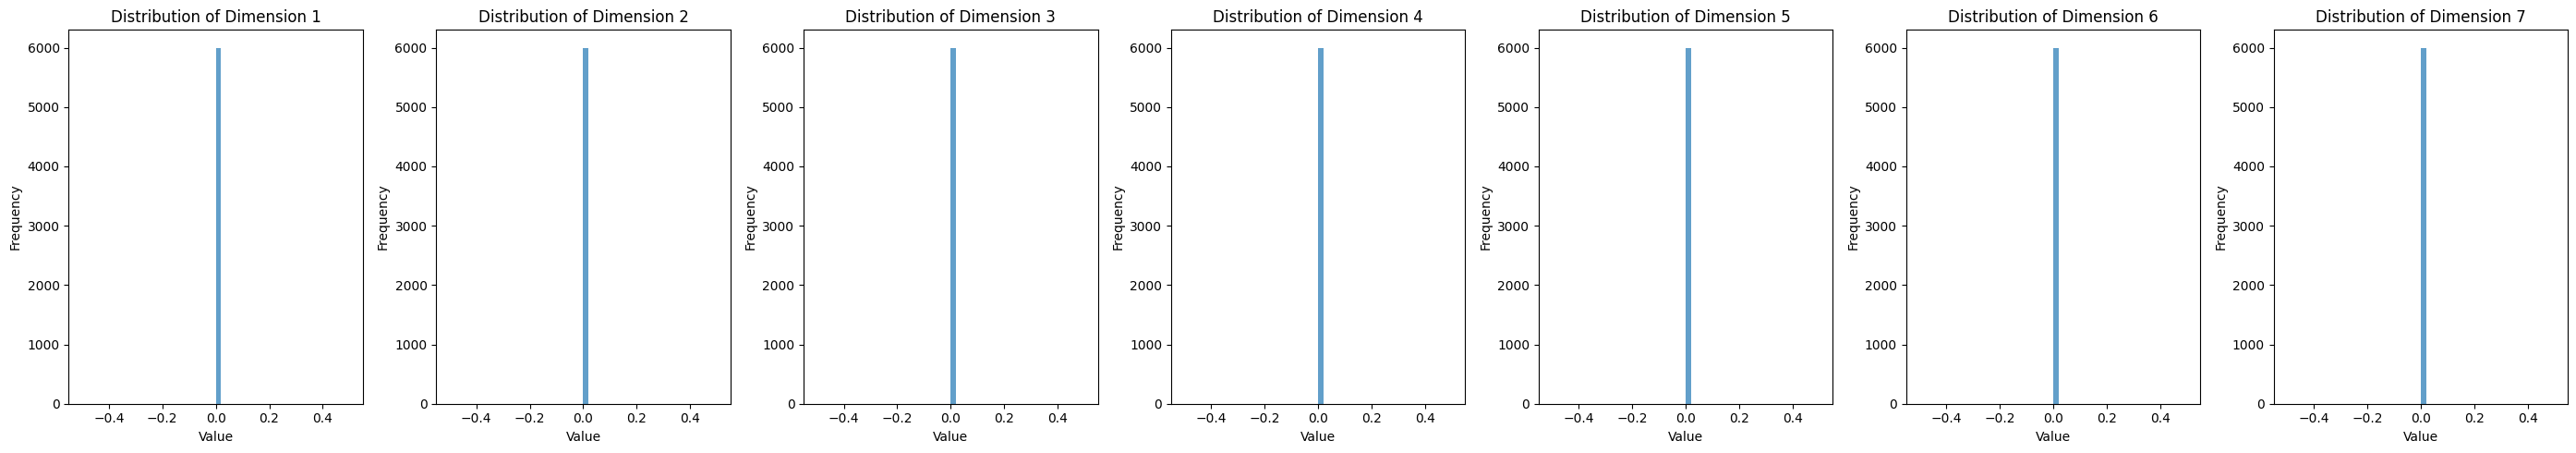

In [ ]:
train_autoencoder()

## Train Auto encoder Round 2

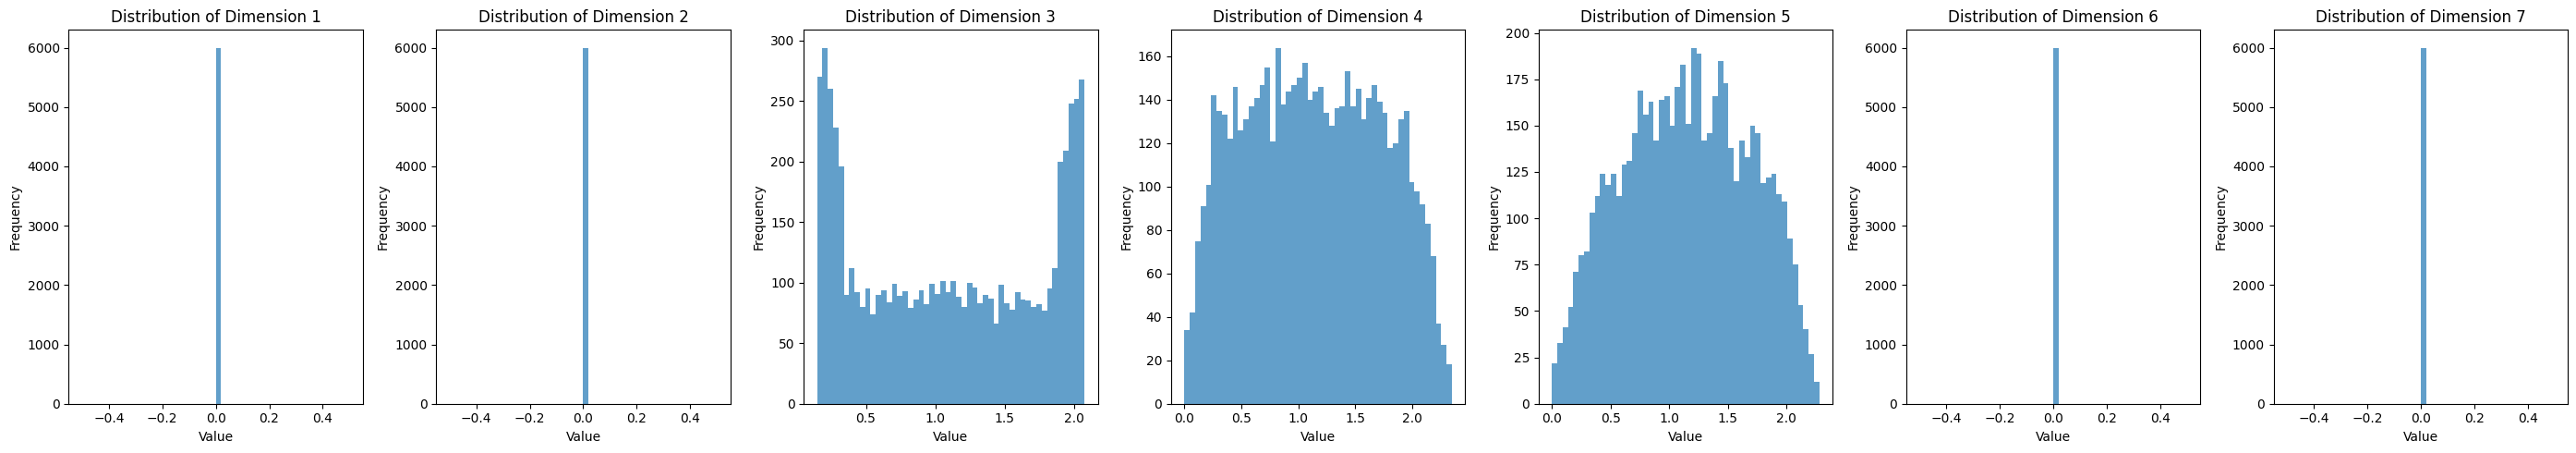

In [ ]:
train_autoencoder()

Above plots shows the distribution of latent varialbles are unstable.

## Evaluate the autoencoder

In [ ]:
bottleneck_dim = 7
model = Autoencoder(bottleneck_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for data, in dataloader:
        outputs = model(data)
        loss = criterion(outputs, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0002
Epoch [2/10], Loss: 0.0001
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [ ]:
model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(points, dtype=torch.float32)).numpy()


## Visualize original and reconstructed points

In [ ]:
# fig = px.scatter_3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], opacity=0.5, title="Original Points")
# fig.show()

In [ ]:
fig = px.scatter_3d(x=reconstructed[:, 0], y=reconstructed[:, 1], z=reconstructed[:, 2], opacity=0.5, title="Reconstructed Points")
fig.show()

## 3. Beta VAE + SNR control the distribution of the latent (bottleneck) variable

In [ ]:
# class VAEWithNoise(nn.Module):
#     def __init__(self, input_dim, bottleneck_dim, snr):
#         super(VAEWithNoise, self).__init__()

#         self.snr = snr

#         # Encoder
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc_mean = nn.Linear(128, bottleneck_dim)
#         self.fc_logvar = nn.Linear(128, bottleneck_dim)

#         # Decoder
#         self.fc2 = nn.Linear(bottleneck_dim, 128)
#         self.fc3 = nn.Linear(128, input_dim)

#     def encode(self, x):
#         h = F.relu(self.fc1(x))
#         return self.fc_mean(h), self.fc_logvar(h)

#     def reparameterize(self, mean, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         z = mean + eps * std

#         # Add noise based on SNR
#         signal_variance = z.var(dim=0, unbiased=False)
#         noise_variance = signal_variance / self.snr
#         noise = torch.randn_like(z) * torch.sqrt(noise_variance)

#         z = z + noise
#         return z

#     def decode(self, z):
#         h = F.relu(self.fc2(z))
#         return torch.sigmoid(self.fc3(h))

#     def forward(self, x):
#         mean, logvar = self.encode(x)
#         z = self.reparameterize(mean, logvar)
#         return self.decode(z), mean, logvar


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BetaVAEWithNoise(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, snr, beta=1.0):
        super(BetaVAEWithNoise, self).__init__()

        self.snr = snr
        self.beta = beta

        # Encoder
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mean = nn.Linear(128, bottleneck_dim)
        self.fc_logvar = nn.Linear(128, bottleneck_dim)

        # Decoder
        self.fc2 = nn.Linear(bottleneck_dim, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std

        # Add noise based on SNR
        signal_variance = z.var(dim=0, unbiased=False)
        noise_variance = signal_variance / self.snr
        noise = torch.randn_like(z) * torch.sqrt(noise_variance)

        z = z + noise
        return z

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # KL divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + self.beta * KLD


In [ ]:
# Loss function
def vae_loss(reconstructed_x, x, mean, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KLD

# Eval Metric

## 1 Generative System:

In [ ]:
def generate_samples(model, num_samples, latent_dim):
    model.eval()
    with torch.no_grad():
        # Sample from the prior distribution (standard Gaussian)
        z = torch.randn(num_samples, latent_dim)
        generated_samples = model.decode(z).cpu().numpy()
    return generated_samples

## 2. Quality Measure: Earth Mover's Distance (EMD):




2. Fréchet Inception Distance (FID):
For simplicity, let's assume you're working with images. If you're working with other types of data, the concept remains the same, but you'd need a different model than Inception v3 to compute features.

In [ ]:
import ot

def compute_emd(samples1, samples2):
    # Compute pairwise distance matrix
    distance_matrix = ot.dist(samples1, samples2)

    # Compute EMD
    emd_value = ot.emd2([], [], distance_matrix)
    return emd_value

# train

In [ ]:
num_samples = n_points_per_face * 6

In [ ]:
import torch.optim as optim

# Hyperparameters to tune
snr_values = [5, 10, 20, 50, 100]
latent_dims = [2, 3, 5, 7, 10]
beta_values = [0.5, 1.0, 2.0, 5.0, 10.0]  # Add beta values to tune

best_emd = float('inf')
best_snr = None
best_latent_dim = None
best_beta = None

for latent_dim in latent_dims:
    for snr in snr_values:
        for beta in beta_values:  # Add loop for beta
            # Initialize and train the VAE
            model = BetaVAEWithNoise(3, latent_dim, snr, beta)  # Use BetaVAEWithNoise
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            num_epochs = 10
            for epoch in range(num_epochs):
                model.train()
                for batch, in dataloader:
                    optimizer.zero_grad()
                    reconstructed_batch, mean, logvar = model(batch)
                    loss = model.loss_function(reconstructed_batch, batch, mean, logvar)  # Use the model's loss function
                    loss.backward()
                    optimizer.step()

            # Generate samples and compute EMD
            generated_points = generate_samples(model, num_samples, latent_dim)
            emd_value = compute_emd(points, generated_points)

            print(f"Latent Dim: {latent_dim}, SNR: {snr}, Beta: {beta}, EMD: {emd_value:.4f}")  # Include beta

            # Update best values
            if emd_value < best_emd:
                best_emd = emd_value
                best_snr = snr
                best_latent_dim = latent_dim
                best_beta = beta  # Update best beta

            model.eval()
            with torch.no_grad():
                # Reconstruction
                reconstructed = model(torch.tensor(points, dtype=torch.float32))[0].numpy()

                # Visualization (using plotly as before)
                fig = px.scatter_3d(x=reconstructed[:, 0], y=reconstructed[:, 1], z=reconstructed[:, 2], opacity=0.5, title="Reconstructed Points")
                fig.write_image(f'reconstructed_{latent_dim}_{snr}_{beta}.png', engine="kaleido")  # Include beta in filename

                # mean, _ = model.encode(torch.tensor(points, dtype=torch.float32))
                # mean = mean.numpy()
                # fig = px.scatter(x=mean[:, 0], y=mean[:, 1], title="Latent Space")
                # fig.show()

print(f"Best Latent Dim: {best_latent_dim}, Best SNR: {best_snr}, Best Beta: {best_beta}, Best EMD: {best_emd:.4f}")  # Include best beta


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 5, Beta: 0.5, EMD: 0.3707


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 5, Beta: 1.0, EMD: 0.3862


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 5, Beta: 2.0, EMD: 0.3949


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 5, Beta: 5.0, EMD: 0.3963


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 5, Beta: 10.0, EMD: 0.3925


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 10, Beta: 0.5, EMD: 0.3325


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 10, Beta: 1.0, EMD: 0.3855


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 10, Beta: 2.0, EMD: 0.3905


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 10, Beta: 5.0, EMD: 0.3866


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 10, Beta: 10.0, EMD: 0.3913


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 20, Beta: 0.5, EMD: 0.2823


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 20, Beta: 1.0, EMD: 0.3918


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 20, Beta: 2.0, EMD: 0.3851


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 20, Beta: 5.0, EMD: 0.3880


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 20, Beta: 10.0, EMD: 0.3972


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 50, Beta: 0.5, EMD: 0.2553


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 50, Beta: 1.0, EMD: 0.3876


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 50, Beta: 2.0, EMD: 0.3935


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 50, Beta: 5.0, EMD: 0.3889


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 50, Beta: 10.0, EMD: 0.3956


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 100, Beta: 0.5, EMD: 0.2495


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 100, Beta: 1.0, EMD: 0.3790


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 100, Beta: 2.0, EMD: 0.3930


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 100, Beta: 5.0, EMD: 0.3952


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 2, SNR: 100, Beta: 10.0, EMD: 0.3887


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 5, Beta: 0.5, EMD: 0.3679


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 5, Beta: 1.0, EMD: 0.3850


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 5, Beta: 2.0, EMD: 0.3824


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 5, Beta: 5.0, EMD: 0.3810


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 5, Beta: 10.0, EMD: 0.3914


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 10, Beta: 0.5, EMD: 0.2890


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 10, Beta: 1.0, EMD: 0.3815


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 10, Beta: 2.0, EMD: 0.3943


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 10, Beta: 5.0, EMD: 0.3773


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 10, Beta: 10.0, EMD: 0.3806


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 20, Beta: 0.5, EMD: 0.2751


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 20, Beta: 1.0, EMD: 0.3798


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 20, Beta: 2.0, EMD: 0.3825


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 20, Beta: 5.0, EMD: 0.3834


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 20, Beta: 10.0, EMD: 0.3945


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 50, Beta: 0.5, EMD: 0.1698


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 50, Beta: 1.0, EMD: 0.3821


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 50, Beta: 2.0, EMD: 0.3753


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 50, Beta: 5.0, EMD: 0.3811


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 50, Beta: 10.0, EMD: 0.3850


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 100, Beta: 0.5, EMD: 0.1770


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 100, Beta: 1.0, EMD: 0.3899


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 100, Beta: 2.0, EMD: 0.3875


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 100, Beta: 5.0, EMD: 0.3924


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 3, SNR: 100, Beta: 10.0, EMD: 0.3809


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 5, Beta: 0.5, EMD: 0.3407


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 5, Beta: 1.0, EMD: 0.3806


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 5, Beta: 2.0, EMD: 0.3837


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 5, Beta: 5.0, EMD: 0.3789


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 5, Beta: 10.0, EMD: 0.3842


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 10, Beta: 0.5, EMD: 0.2985


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 10, Beta: 1.0, EMD: 0.3637


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 10, Beta: 2.0, EMD: 0.3816


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 10, Beta: 5.0, EMD: 0.3845


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 10, Beta: 10.0, EMD: 0.3816


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 20, Beta: 0.5, EMD: 0.2691


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 20, Beta: 1.0, EMD: 0.3736


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 20, Beta: 2.0, EMD: 0.3870


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 20, Beta: 5.0, EMD: 0.3844


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 20, Beta: 10.0, EMD: 0.3849


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 50, Beta: 0.5, EMD: 0.2009


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 50, Beta: 1.0, EMD: 0.3812


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 50, Beta: 2.0, EMD: 0.3782


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 50, Beta: 5.0, EMD: 0.3879


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 50, Beta: 10.0, EMD: 0.3760


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 100, Beta: 0.5, EMD: 0.1894


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 100, Beta: 1.0, EMD: 0.3669


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 100, Beta: 2.0, EMD: 0.3711


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 100, Beta: 5.0, EMD: 0.3835


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 5, SNR: 100, Beta: 10.0, EMD: 0.3741


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 5, Beta: 0.5, EMD: 0.3163


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 5, Beta: 1.0, EMD: 0.3684


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 5, Beta: 2.0, EMD: 0.3847


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 5, Beta: 5.0, EMD: 0.3838


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 5, Beta: 10.0, EMD: 0.3739


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 10, Beta: 0.5, EMD: 0.3160


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 10, Beta: 1.0, EMD: 0.3861


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 10, Beta: 2.0, EMD: 0.3819


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 10, Beta: 5.0, EMD: 0.3783


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 10, Beta: 10.0, EMD: 0.3828


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 20, Beta: 0.5, EMD: 0.2302


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 20, Beta: 1.0, EMD: 0.3737


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 20, Beta: 2.0, EMD: 0.3774


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 20, Beta: 5.0, EMD: 0.3824


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 20, Beta: 10.0, EMD: 0.3752


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 50, Beta: 0.5, EMD: 0.2446


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 50, Beta: 1.0, EMD: 0.3704


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 50, Beta: 2.0, EMD: 0.3746


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 50, Beta: 5.0, EMD: 0.3810


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 50, Beta: 10.0, EMD: 0.3793


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 100, Beta: 0.5, EMD: 0.2059


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 100, Beta: 1.0, EMD: 0.3681


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 100, Beta: 2.0, EMD: 0.3788


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 100, Beta: 5.0, EMD: 0.3827


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 7, SNR: 100, Beta: 10.0, EMD: 0.3856


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 5, Beta: 0.5, EMD: 0.3218


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 5, Beta: 1.0, EMD: 0.3759


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 5, Beta: 2.0, EMD: 0.3772


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 5, Beta: 5.0, EMD: 0.3750


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 5, Beta: 10.0, EMD: 0.3815


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 10, Beta: 0.5, EMD: 0.3014


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 10, Beta: 1.0, EMD: 0.3673


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 10, Beta: 2.0, EMD: 0.3769


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 10, Beta: 5.0, EMD: 0.3815


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 10, Beta: 10.0, EMD: 0.3774


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 20, Beta: 0.5, EMD: 0.2356


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 20, Beta: 1.0, EMD: 0.3704


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 20, Beta: 2.0, EMD: 0.3775


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 20, Beta: 5.0, EMD: 0.3802


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 20, Beta: 10.0, EMD: 0.3840


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 50, Beta: 0.5, EMD: 0.2558


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 50, Beta: 1.0, EMD: 0.3773


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 50, Beta: 2.0, EMD: 0.3768


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 50, Beta: 5.0, EMD: 0.3804


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 50, Beta: 10.0, EMD: 0.3787


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 100, Beta: 0.5, EMD: 0.2290


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 100, Beta: 1.0, EMD: 0.3620


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 100, Beta: 2.0, EMD: 0.3784


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 100, Beta: 5.0, EMD: 0.3734


/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



Latent Dim: 10, SNR: 100, Beta: 10.0, EMD: 0.3772
Best Latent Dim: 3, Best SNR: 50, Best Beta: 0.5, Best EMD: 0.1698


In [ ]:
# # Hyperparameters to tune
# snr_values = [5, 10, 20, 50, 100]
# latent_dims = [2, 3, 5, 7, 10]

# best_emd = float('inf')
# best_snr = None
# best_latent_dim = None

# for latent_dim in latent_dims:
#     for snr in snr_values:
#         # Initialize and train the VAE
#         model = BetaVAE(3, latent_dim, snr)
#         optimizer = optim.Adam(model.parameters(), lr=0.001)

#         num_epochs = 10
#         for epoch in range(num_epochs):
#             model.train()
#             for batch, in dataloader:
#                 optimizer.zero_grad()
#                 reconstructed_batch, mean, logvar = model(batch)
#                 loss = vae_loss(reconstructed_batch, batch, mean, logvar)
#                 loss.backward()
#                 optimizer.step()

#         # Generate samples and compute EMD
#         generated_points = generate_samples(model, num_samples, latent_dim)
#         emd_value = compute_emd(points, generated_points)

#         print(f"Latent Dim: {latent_dim}, SNR: {snr}, EMD: {emd_value:.4f}")

#         # Update best values
#         if emd_value < best_emd:
#             best_emd = emd_value
#             best_snr = snr
#             best_latent_dim = latent_dim

#         model.eval()
#         with torch.no_grad():
#             # Reconstruction
#             reconstructed = model(torch.tensor(points, dtype=torch.float32))[0].numpy()

#             # # Visualization (using plotly as before)
#             # fig = px.scatter_3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], opacity=0.5, title="Original Points")
#             # fig.show()

#             fig = px.scatter_3d(x=reconstructed[:, 0], y=reconstructed[:, 1], z=reconstructed[:, 2], opacity=0.5, title="Reconstructed Points")
#             fig.write_image(f'reconstructed_{latent_dim}_{snr}.png', engine="kaleido")

#             # mean, _ = model.encode(torch.tensor(points, dtype=torch.float32))
#             # mean = mean.numpy()
#             # fig = px.scatter(x=mean[:, 0], y=mean[:, 1], title="Latent Space")
#             # fig.show()

# print(f"Best Latent Dim: {best_latent_dim}, Best SNR: {best_snr}, Best EMD: {best_emd:.4f}")

# 4. Evaluate the autoencoder

In [ ]:
def plot_histograms(model, data_loader):
    """
    Plot histograms for each dimension of the bottleneck layer.

    Args:
    - model: The VAEWithNoise model.
    - data_loader: DataLoader containing the data to be passed through the model.
    """
    model.eval()  # Set the model to evaluation mode
    all_z = []

    with torch.no_grad():
        for batch_data, in data_loader:  # Note the comma to unpack the tuple
            mean, logvar = model.encode(batch_data)
            z = model.reparameterize(mean, logvar)
            all_z.append(z)

    all_z = torch.cat(all_z, dim=0)  # Concatenate all the bottleneck values
    num_dimensions = all_z.size(1)

    # Ensure don't try to plot more subplots than dimensions
    num_rows, num_cols = 2, 5
    assert num_dimensions <= num_rows * num_cols, "Too many dimensions for the specified subplot grid."

    # Plot histograms
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    for i in range(num_dimensions):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].hist(all_z[:, i].numpy(), bins=50, density=True)
        axes[row, col].set_title(f'Dimension {i + 1}')

    plt.tight_layout()
    plt.show()

In [ ]:
def train_autoencoder():
    # Initialize the VAE model
    input_dim = 3  # For 3D data
    bottleneck_dim = 3
    snr = 50
    beta = 0.5
    # model = VAEWithNoise(input_dim, bottleneck_dim, snr)
    model = BetaVAEWithNoise(input_dim, bottleneck_dim, snr, beta)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch, in dataloader:
            optimizer.zero_grad()
            reconstructed_batch, mean, logvar = model(batch)
            loss = vae_loss(reconstructed_batch, batch, mean, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(dataset):.6f}")
    plot_histograms(model, dataloader)

Epoch 1/10, Loss: 2.099367
Epoch 2/10, Loss: 2.086336
Epoch 3/10, Loss: 2.082986
Epoch 4/10, Loss: 2.080571
Epoch 5/10, Loss: 2.081198
Epoch 6/10, Loss: 2.080297
Epoch 7/10, Loss: 2.080454
Epoch 8/10, Loss: 2.080423
Epoch 9/10, Loss: 2.080258
Epoch 10/10, Loss: 2.080107


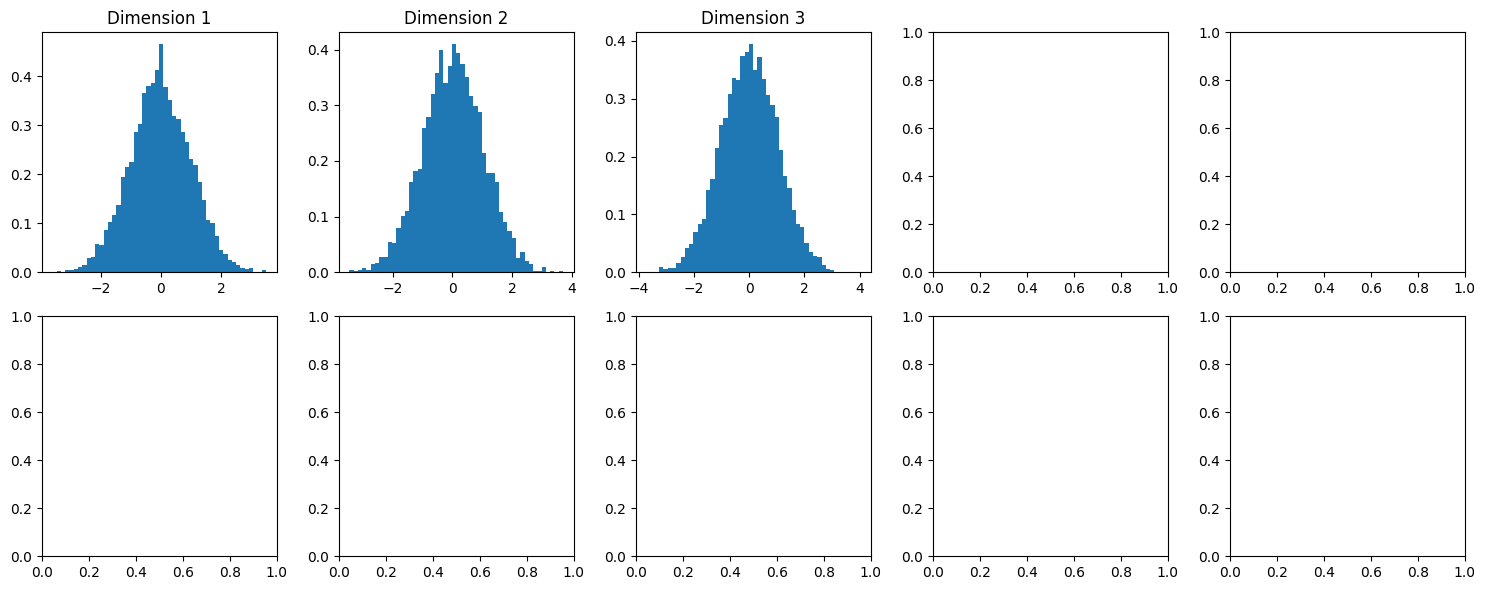

In [ ]:
# round 1
train_autoencoder()

Epoch 1/10, Loss: 2.104060
Epoch 2/10, Loss: 2.086316
Epoch 3/10, Loss: 2.082365
Epoch 4/10, Loss: 2.080725
Epoch 5/10, Loss: 2.080404
Epoch 6/10, Loss: 2.080531
Epoch 7/10, Loss: 2.080155
Epoch 8/10, Loss: 2.080302
Epoch 9/10, Loss: 2.080258
Epoch 10/10, Loss: 2.080041


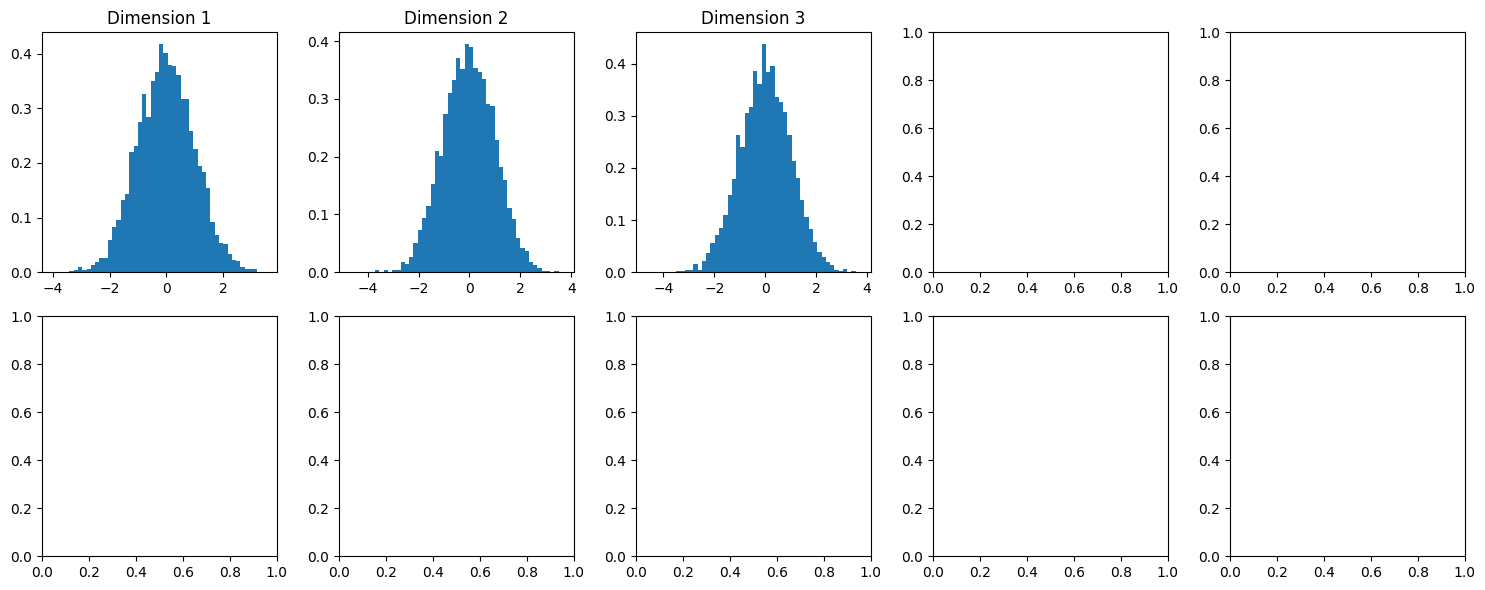

In [ ]:
# round 2
train_autoencoder()

# Eval Model

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    # Reconstruction
    reconstructed = model(torch.tensor(points, dtype=torch.float32))[0].numpy()

    # Visualization (using plotly as before)
    fig = px.scatter_3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], opacity=0.5, title="Original Points")
    fig.show()

    fig = px.scatter_3d(x=reconstructed[:, 0], y=reconstructed[:, 1], z=reconstructed[:, 2], opacity=0.5, title="Reconstructed Points")
    fig.show()

    # If bottleneck_dim is 2, visualize the latent space
    # mean, _ = model.encode(torch.tensor(points, dtype=torch.float32))
    # mean = mean.numpy()
    # fig = px.scatter(x=mean[:, 0], y=mean[:, 1], title="Latent Space")
    # fig.show()


# Estimate or bound the information in bits passing through the latent layer for your settings. Attempt to explain what this information represents for your reconstruction.

In [ ]:
import numpy as np
import torch
from scipy.stats import norm

def estimate_entropy(samples):
    # Using kernel density estimation to estimate the probability density
    kde = norm(np.mean(samples), np.std(samples))
    pdf_values = kde.pdf(samples)

    # Avoid log(0) by adding a small constant
    pdf_values[pdf_values == 0] = 1e-10

    # Compute entropy
    entropy = -np.mean(np.log2(pdf_values))
    return entropy

latent_samples = []

model.eval()
with torch.no_grad():
    for batch, in dataloader:
        mean, logvar = model.encode(batch)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_samples = mean + eps * std
        latent_samples.append(z_samples.cpu().numpy())

latent_samples = np.concatenate(latent_samples, axis=0)

# Estimate entropy for each dimension in the latent space
entropies = [estimate_entropy(latent_samples[:, i]) for i in range(bottleneck_dim)]

# Mutual information is approximately equal to the entropy in VAEs
mutual_informations = entropies

print(f"Entropies: {entropies}")
print(f"Mutual Informations: {mutual_informations}")

Entropies: [2.0350299509661647, 2.048126149952908, 2.0492657997923907, 2.0545085419596525, 2.0572429958141742, 2.043310198328894, 2.0444053671216436]
Mutual Informations: [2.0350299509661647, 2.048126149952908, 2.0492657997923907, 2.0545085419596525, 2.0572429958141742, 2.043310198328894, 2.0444053671216436]
